In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import brainsss
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

from scipy.fftpack import fft,fftshift,ifft
import tqdm

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [3]:
fictrac = []
fictrac_fwd = []
fictrac_any = []
for fly in fly_names:
    
    fictrac_raw = brainsss.load_fictrac(os.path.join(dataset_path, fly, 'func_0', 'fictrac'))

    # Smooth raw fictrac data
    behavior = 'dRotLabZ'
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    fps=50
    fictrac_smoothed = fictrac_smoothed * 180 / np.pi * fps # now in deg/sec
    fictrac.append(fictrac_smoothed)
    
    #also get fwd
    sphere_radius = 4.5e-3 # in m
    behavior = 'dRotLabY'
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    fps=50
    fictrac_smoothed = fictrac_smoothed * sphere_radius * fps * 1000 # now in mm/sec
    fictrac_fwd.append(fictrac_smoothed)
    
    # also get "any" ball movement
    any_rot = np.sqrt(np.asarray(fictrac_raw['dRotLabZ'])**2 +
    np.asarray(fictrac_raw['dRotLabY'])**2 +
    np.asarray(fictrac_raw['dRotLabX'])**2)
    any_rot_smoothed = scipy.signal.savgol_filter(any_rot,25,3)
    fictrac_any.append(any_rot_smoothed)

In [4]:
turn_thresh = 200

peaks_all_fly = []
peak_heights_all_fly = []
for fly in range(9):
    peaks = {'L':[],'R':[]}
    heights = {'L':[],'R':[]}
    for turn,scalar in zip(['L', 'R'],[1,-1]):
        
        found_peaks = scipy.signal.find_peaks(fictrac[fly]*scalar, height=turn_thresh)
        pks = found_peaks[0]
        pk_height = found_peaks[1]['peak_heights']
        
        ### remove peaks that are too close to beginning or end
        # will do 20sec window
        # here 20sec is 1000 tps
        ind = np.where(pks>88000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        ind = np.where(pks<2000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        peaks[turn] = pks
        heights[turn] = pk_height
    peaks_all_fly.append(peaks)
    peak_heights_all_fly.append(heights)

In [5]:
#final_flies = [0,4,6,7,8]
final_flies = [0,1,2,3,4,5,6,7,8]

window = 1500
beh_traces_L = []
beh_traces_R = []

for fly in final_flies:
    
    beh_traces_L_fly = []
    beh_traces_R_fly = []
    
    for beh in ['L', 'R']:
        peaks_in_ms = peaks_all_fly[fly][beh]
        for peak in peaks_in_ms:
            bout = fictrac[fly][peak-window:peak+window]
            if beh == 'L':
                beh_traces_L_fly.append(bout)
            elif beh == 'R':
                beh_traces_R_fly.append(bout)
                
    beh_traces_L.append(np.asarray(beh_traces_L_fly))
    beh_traces_R.append(np.asarray(beh_traces_R_fly))
    
beh_traces_L_stacked = np.empty((0,window*2))
beh_traces_R_stacked = np.empty((0,window*2))

for fly in range(len(final_flies)):
    beh_traces_L_stacked = np.concatenate((beh_traces_L_stacked, beh_traces_L[fly]))
    beh_traces_R_stacked = np.concatenate((beh_traces_R_stacked, beh_traces_R[fly]))

In [6]:
# high res behavior
beh_high_res = {'L': beh_traces_L_stacked,
                'R': beh_traces_R_stacked}

beh_high_res['L'].shape, beh_high_res['R'].shape

((1362, 3000), (2424, 3000))

In [7]:
num_bouts_L = []
num_bouts_R = []
for i in range(len(peaks_all_fly)):
    num_bouts_L.append(len(peaks_all_fly[i]['L']))
    num_bouts_R.append(len(peaks_all_fly[i]['R']))
num_bouts_L = np.cumsum(num_bouts_L)
num_bouts_R = np.cumsum(num_bouts_R)

nbL = np.insert(num_bouts_L,0,0)
nbR = np.insert(num_bouts_R,0,0)

for fly in range(len(peaks_all_fly)):
    print(nbL[fly+1]-nbL[fly], nbR[fly+1]-nbR[fly])

222 519
38 33
140 2
47 105
178 291
27 543
364 601
276 219
70 111


In [64]:
len(final_flies)

9

In [62]:
fly = 1
range(nbL[fly],nbL[fly+1])

range(222, 260)

In [8]:
start = 750
stop = 1100

fly_accuracies = []
for fly in range(len(final_flies)):
    # first do left turns
    # this will make a vector where 1 correctly predicts a L, and 0 is incorrect
    prediction = []
    n_turns = nbL[fly+1] - nbL[fly]
    for i in range(nbL[fly],nbL[fly+1]):
        early_behavior = np.mean(beh_high_res['L'][i][start:stop])
        if early_behavior > 0:
            prediction.append(1)
        else:
            prediction.append(0)
    correct_count = np.sum(prediction)
    accuracy_L = correct_count/n_turns

    # right turns
    prediction = []
    n_turns = nbR[fly+1] - nbR[fly]
    for i in range(nbR[fly],nbR[fly+1]):
        early_behavior = np.mean(beh_high_res['R'][i][start:stop])
        if early_behavior < 0:
            prediction.append(1)
        else:
            prediction.append(0)
    correct_count = np.sum(prediction)
    accuracy_R = correct_count/n_turns

    accuracy = (accuracy_L+accuracy_R)/2
    fly_accuracies.append(accuracy)

In [101]:
(0.1+0.9)/2

0.5

In [9]:
fly_accuracies

[0.47583710878508567,
 0.5271132376395534,
 0.8571428571428572,
 0.6457953394123607,
 0.5728889146299085,
 0.5612850419480254,
 0.5080406282569344,
 0.5031268612269207,
 0.5701415701415701]

In [10]:
[fly_accuracies[i] for i in [0,4,6,7,8]]

[0.47583710878508567,
 0.5728889146299085,
 0.5080406282569344,
 0.5031268612269207,
 0.5701415701415701]

In [ ]:
[0,4,6,7,8]

# bootstrap version

In [21]:
from random import choices

In [22]:
start = 750
stop = 1100
n_bout = 1000 #bootstrap sample

boot_accuracies = []
for iteration in tqdm.tqdm(range(100)):
    fly_accuracies = []
    for fly in range(len(final_flies)):
        # first do left turns
        # this will make a vector where 1 correctly predicts a L, and 0 is incorrect
        prediction = []
        bt_L = choices(range(nbL[fly],nbL[fly+1]), k=n_bout)
        for i in bt_L:
            early_behavior = np.mean(beh_high_res['L'][i][start:stop])
            if early_behavior > 0:
                prediction.append(1)
            else:
                prediction.append(0)
        correct_count = np.sum(prediction)
        accuracy_L = correct_count/n_bout

        # right turns
        prediction = []
        bt_R = choices(range(nbR[fly],nbR[fly+1]), k=n_bout)
        for i in bt_R:
            early_behavior = np.mean(beh_high_res['R'][i][start:stop])
            if early_behavior < 0:
                prediction.append(1)
            else:
                prediction.append(0)
        correct_count = np.sum(prediction)
        accuracy_R = correct_count/n_bout

        accuracy = (accuracy_L+accuracy_R)/2
        fly_accuracies.append(accuracy)
    boot_accuracies.append(np.asarray(fly_accuracies))
boot_accuracies = np.asarray(boot_accuracies)

100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


In [81]:
boot_accuracies.shape

(100, 9)

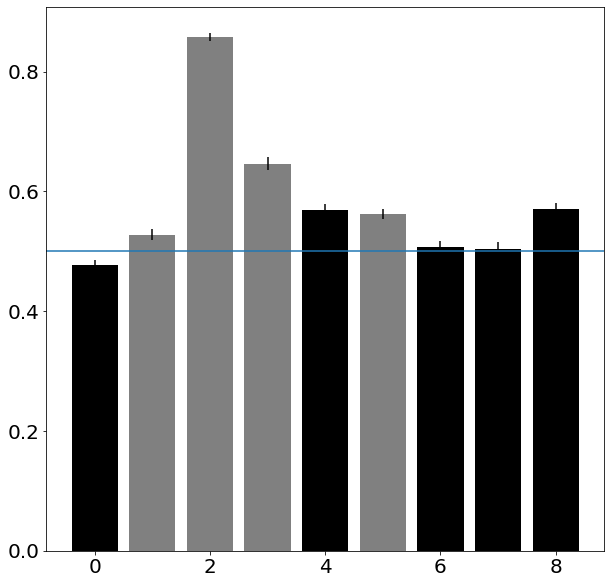

In [23]:
plt.figure(figsize=(10,10))

for k in range(9):
    if k in [0,4,6,7,8]:
        color='k'
    else:
        color='grey'
    plt.bar([k],np.mean(boot_accuracies,axis=0)[k],yerr=np.std(boot_accuracies,axis=0)[k],color=color)
#plt.ylim(.4,.8)
#plt.ylabel('accuracy')
#plt.xticks([0,1,2,3],['all_bouts\nearly','all_bouts\nt=0','27_bouts\nearly','27_bouts\nt=0'])

plt.axhline(0.5)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [24]:
np.mean(boot_accuracies,axis=0)[[0,4,6,7,8]]

array([0.476985, 0.56951 , 0.507235, 0.504195, 0.57    ])

In [25]:
scipy.stats.ttest_1samp(np.mean(boot_accuracies,axis=0)[[0,4,6,7,8]], popmean=0.5)

Ttest_1sampResult(statistic=1.3619149256290504, pvalue=0.24487938262417114)

In [16]:
scipy.stats.ttest_1samp([fly_accuracies[i] for i in [0,4,6,7,8]], popmean=0.5)

Ttest_1sampResult(statistic=1.3421840313362254, pvalue=0.25065448037167454)

In [28]:
np.std([fly_accuracies[i] for i in [0,4,6,7,8]])#/np.sqrt(5)

0.036057731487158205

2.23606797749979

In [31]:
.5761*.36*2/np.sqrt(5)

0.1855006217046185

In [26]:
np.average(np.mean(boot_accuracies,axis=0)[[0,4,6,7,8]],weights=[222+519, 178+291, 364+601, 276+219, 70+111])

0.5130741406524029

In [27]:
np.average(np.mean(boot_accuracies,axis=0)[[0,4,6,7,8]])

0.5255850000000002

In [83]:
fly_accuracies

[0.483, 0.5355, 0.853, 0.652, 0.566, 0.555, 0.531, 0.496, 0.566]

In [87]:
222+519, 178+291, 364+601, 276+219, 70+111

(741, 469, 965, 495, 181)

In [ ]:
222 519#
38 33
140 2
47 105
178 291#
27 543
364 601#
276 219#
70 111#

In [11]:
xs = np.arange(0,30000,20) #change to 60 if changed above
xs = np.concatenate((xs[::-1]*-1, xs))/1000

In [13]:
xs[750], xs[1100]

(-14.98, -7.98)

In [ ]:
# because the flies are biased to turn right, 

In [56]:
nbR

array([   0,  519,  552,  554,  659,  950, 1493, 2094, 2313, 2424])

In [55]:
start = 750
stop = 1100

fly_accuracies = []
for fly in range(len(nbR)):
    # first do left turns
    # this will make a vector where 1 correctly predicts a L, and 0 is incorrect
    prediction = []
    n_turns = 222
    for i in range(n_turns):
        early_behavior = np.mean(beh_high_res['L'][i][start:stop])
        if early_behavior > 0:
            prediction.append(1)
        else:
            prediction.append(0)
    correct_count = np.sum(prediction)
    accuracy_L = correct_count/n_turns

    # right turns
    prediction = []
    n_turns = 519
    for i in range(n_turns):
        early_behavior = np.mean(beh_high_res['R'][i][start:stop])
        if early_behavior < 0:
            prediction.append(1)
        else:
            prediction.append(0)
    correct_count = np.sum(prediction)
    accuracy_R = correct_count/n_turns

    accuracy = (accuracy_L+accuracy_R)/2
    fly_accuracies.append(accuracy)

0.47583710878508567

In [50]:
correct_count/n_turns

0.25225225225225223

In [53]:
accuracy_R

0.6994219653179191

In [45]:
np.sum(prediction)

56

In [47]:
222-56

166

In [42]:
56/222

0.25225225225225223

In [36]:
np.sum(prediction)

363

In [41]:
.95/2

0.475

In [40]:
363/519

0.6994219653179191

In [37]:
519-363

156

In [38]:
56/222

0.25225225225225223

In [29]:
636/1362

0.4669603524229075

In [30]:
1701/2424

0.7017326732673267

In [ ]:
num_bout = 30

start = 32
stop = 57

# start = 59
# stop = 61
accuracy = []
for num_bout in range(0,1300):
    beh = 'R'
    R = np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],start:stop],axis=1)
    beh = 'L'
    L = np.mean(neural_low_res[beh][bouts_filtered[beh][:num_bout],start:stop],axis=1)
    #R.shape, L.shape

    thresh = 0
    num_correct = np.sum(L<thresh) + np.sum(R>thresh)
    accuracy.append(num_correct/(num_bout*2))